# Customer Re-engagement Opportunity

**Data source:** `marts.orders` and `marts.customers`  
**Question:** Where is the highest-leverage intervention to grow repeat revenue?

In [7]:
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import warnings

warnings.filterwarnings("ignore", message="BigQuery Storage module not found")

client = bigquery.Client(project="airalo-486008")

def run(sql):
    df = client.query(sql).to_dataframe()
    for col in df.select_dtypes(include=["object"]).columns:
        try:
            df[col] = pd.to_numeric(df[col])
        except (ValueError, TypeError):
            pass
    return df

plt.rcParams.update({
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "axes.grid": True,
    "grid.alpha": 0.3,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "font.size": 11,
})

BLUE = "#4A90D9"
ORANGE = "#E8833A"
GREEN = "#5CB85C"
GREY = "#AAAAAA"

---
## Recommendations

1. **Launch a 3-stage re-engagement sequence** targeting one-time buyers who had a positive experience (no refunds, no support escalations): light nudge at day 7-14, strongest offer at day 21-35, final push at day 60-75. The 90-day window captures 94% of all repeat behavior. *(See: [The Re-engagement Window](#3.-The-Re-engagement-Window))*

2. **Start with organic-acquired customers** as the test cohort. They have the lowest 90-day repeat rate (`customers.has_repeat_within_90d`), the largest addressable pool, and the most room for improvement. *(See: [Channel Quality](#4.-Channel-Quality-+-Organic-Opportunity))*

3. **Prioritize affiliate and referral for acquisition spend.** These channels produce the highest-quality customers by 90-day repeat rate. Every dollar spent here is more likely to generate long-term value. *(See: [Channel Quality](#4.-Channel-Quality-+-Organic-Opportunity))*

4. **Focus on frequency, not basket size.** AOV is flat across purchase numbers (~$27). The path to more revenue is more repeat purchases, not larger orders.

5. **Track `customers.has_repeat_within_90d` by cohort as the north-star metric.** It matures quickly, captures nearly all repeat behavior, and allows fair month-over-month comparison. Note: cohort trend analysis requires the full customer population — see [Limitations](#Limitations) for why we didn't include it here.

6. **Investigate which first-purchase packages drive the highest repeat rates** and consider promoting high-retention packages more prominently in the storefront or as default recommendations for new customers. *(See: [Repeat Rates by eSIM Package](#5.-Repeat-Rates-by-eSIM-Package))*

7. **Understand refund and failure recovery patterns** to size the re-engagement opportunity among customers with negative experiences and determine whether a dedicated recovery flow is warranted. *(See: [Refund & Failure Impact](#6.-Refund-&-Failure-Impact-on-Repeat-Behavior))*

The analysis below walks through the evidence behind each recommendation.

---
## 1. The Headline

In [8]:
headline = run("""
SELECT
    COUNTIF(total_purchases > 0) AS buyers,
    COUNTIF(is_repeat_purchaser) AS repeat_buyers,
    ROUND(COUNTIF(is_repeat_purchaser) * 100.0
        / NULLIF(COUNTIF(total_purchases > 0), 0), 1) AS repeat_rate_pct,
    ROUND(SUM(CASE WHEN is_repeat_purchaser THEN total_revenue_usd ELSE 0 END) * 100.0
        / NULLIF(SUM(CASE WHEN total_purchases > 0 THEN total_revenue_usd END), 0), 1)
        AS repeat_revenue_pct
FROM `airalo-486008.marts.customers`
""")

r = headline.iloc[0]
print(f"Repeat rate:       {r['repeat_rate_pct']:.0f}% of buyers make 2+ purchases  (customers.is_repeat_purchaser)")
print(f"Revenue share:     {r['repeat_revenue_pct']:.0f}% of revenue comes from repeat buyers")
print(f"                   ({int(r['repeat_buyers'])} of {int(r['buyers'])} buyers)")
print()
print(f"→ {100 - r['repeat_rate_pct']:.0f}% of customers buy once and never return,")
print(f"  but the {r['repeat_rate_pct']:.0f}% who do repeat generate {r['repeat_revenue_pct']:.0f}% of all revenue.")

Repeat rate:       43% of buyers make 2+ purchases  (customers.is_repeat_purchaser)
Revenue share:     79% of revenue comes from repeat buyers
                   (426 of 987 buyers)

→ 57% of customers buy once and never return,
  but the 43% who do repeat generate 79% of all revenue.


---
## 2. The 1st → 2nd Purchase Cliff

Where exactly do customers drop off? If the biggest loss is between purchase 1 and 2, that's where intervention matters most.

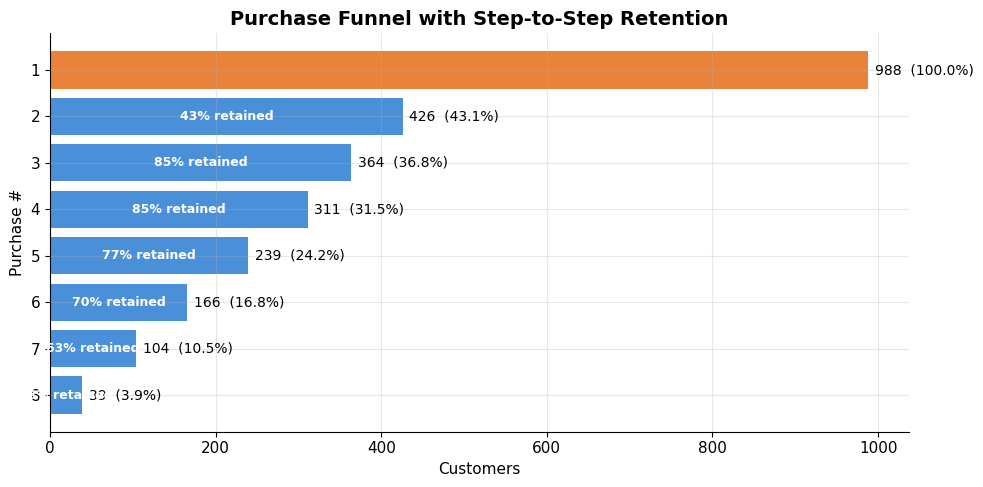

In [9]:
funnel = run("""
WITH purchase_counts AS (
    SELECT
        customer_purchase_number,
        COUNT(DISTINCT user_id) AS customers
    FROM `airalo-486008.marts.orders`
    WHERE NOT order_is_failed
    GROUP BY 1
)
SELECT
    customer_purchase_number AS purchase_n,
    customers,
    ROUND(customers * 100.0
        / FIRST_VALUE(customers) OVER (ORDER BY customer_purchase_number), 1)
        AS pct_of_original,
    ROUND(customers * 100.0
        / NULLIF(LAG(customers) OVER (ORDER BY customer_purchase_number), 0), 1)
        AS retention_from_prev
FROM purchase_counts
WHERE customer_purchase_number BETWEEN 1 AND 8
ORDER BY 1
""")

fig, ax = plt.subplots(figsize=(10, 5))

colors = [ORANGE if i == 0 else BLUE for i in range(len(funnel))]
bars = ax.barh(funnel["purchase_n"].astype(str), funnel["customers"], color=colors)
ax.set_xlabel("Customers")
ax.set_ylabel("Purchase #")
ax.set_title("Purchase Funnel with Step-to-Step Retention", fontsize=14, fontweight="bold")
ax.invert_yaxis()

for i, row in funnel.iterrows():
    ax.text(row["customers"] + 8, i,
            f"{int(row['customers'])}  ({row['pct_of_original']}%)",
            va="center", fontsize=10)
    if pd.notna(row["retention_from_prev"]):
        ax.annotate(f"{row['retention_from_prev']:.0f}% retained",
                    xy=(row["customers"] * 0.5, i),
                    fontsize=9, color="white", fontweight="bold",
                    ha="center", va="center")

plt.tight_layout()
plt.show()

**57% of buyers never make a second purchase** — the 1→2 cliff is by far the steepest drop. But once a customer returns, retention stabilizes around 85%+ from purchase 2 onward.

Not all of that 57% is addressable. Some had bad experiences (connectivity, billing), some were one-time travelers, some simply didn't like the product. In production, re-engagement should target the subset with positive signals — no refunds, no support escalations, good NPS/CSAT if available. The 57% is the ceiling, not the campaign audience.

---
## 3. The Re-engagement Window

When do second purchases happen? This sets the timing for any re-engagement campaign. Uses `customers.days_to_second_purchase` directly from the mart.

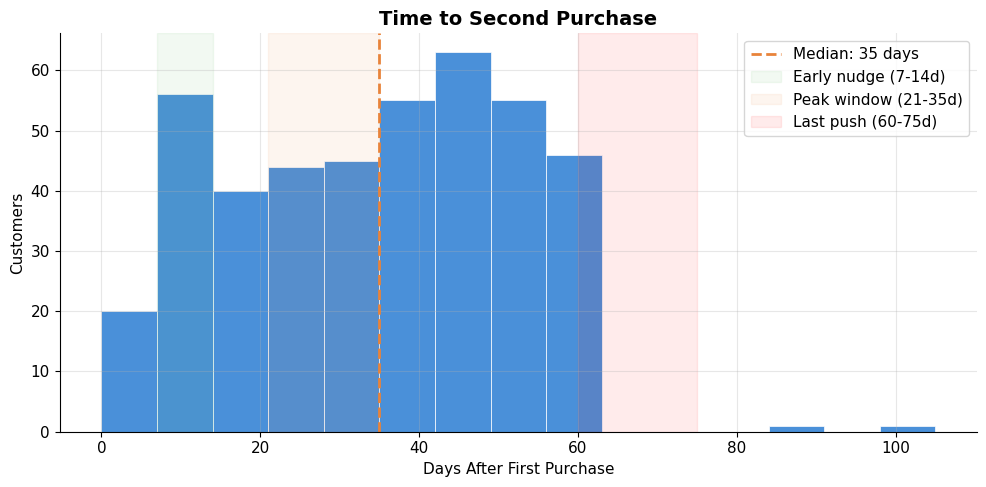

Median: 35 days  |  100% of second purchases happen within 90 days


In [10]:
time_to_2nd = run("""
SELECT days_to_second_purchase AS days
FROM `airalo-486008.marts.customers`
WHERE days_to_second_purchase IS NOT NULL
""")

fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(time_to_2nd["days"], bins=range(0, int(time_to_2nd["days"].max()) + 7, 7),
        color=BLUE, edgecolor="white", linewidth=0.5)

median_d = time_to_2nd["days"].median()
ax.axvline(median_d, color=ORANGE, linestyle="--", linewidth=2,
           label=f"Median: {median_d:.0f} days")

ax.axvspan(7, 14, alpha=0.08, color=GREEN, label="Early nudge (7-14d)")
ax.axvspan(21, 35, alpha=0.08, color=ORANGE, label="Peak window (21-35d)")
ax.axvspan(60, 75, alpha=0.08, color="red", label="Last push (60-75d)")

ax.set_xlabel("Days After First Purchase")
ax.set_ylabel("Customers")
ax.set_title("Time to Second Purchase", fontsize=14, fontweight="bold")
ax.legend(loc="upper right")
plt.tight_layout()
plt.show()

pct_90 = (time_to_2nd["days"] <= 90).mean() * 100
print(f"Median: {median_d:.0f} days  |  {pct_90:.0f}% of second purchases happen within 90 days")

**Campaign timing recommendation:**
- **Day 7-14:** Early nudge — light reminder for the fastest converters
- **Day 21-35:** Peak window — strongest push (median is ~35 days)
- **Day 60-75:** Last push — final offer before the window closes
- After 90 days, customers are essentially lost (~94% of repeats have already happened)

---
## 4. Channel Quality + Organic Opportunity

Which acquisition channels produce customers most likely to repeat? Uses `customers.has_repeat_within_90d` and `customers.acquisition_channel` from the mart to compare with a standardized 90-day window.

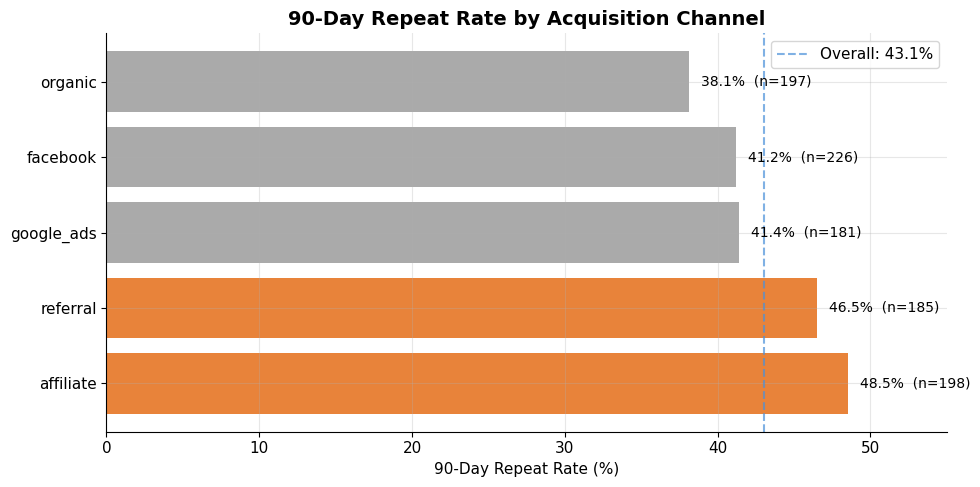

In [11]:
channels = run("""
SELECT
    acquisition_channel,
    COUNTIF(total_purchases > 0) AS buyers,
    COUNTIF(has_repeat_within_90d) AS repeat_90d,
    ROUND(COUNTIF(has_repeat_within_90d) * 100.0
        / NULLIF(COUNTIF(total_purchases > 0), 0), 1) AS repeat_rate_90d
FROM `airalo-486008.marts.customers`
GROUP BY 1
ORDER BY repeat_rate_90d DESC
""")

fig, ax = plt.subplots(figsize=(10, 5))

overall_rate = channels["repeat_90d"].sum() / channels["buyers"].sum() * 100
colors = [ORANGE if v >= overall_rate else GREY for v in channels["repeat_rate_90d"]]

ax.barh(channels["acquisition_channel"], channels["repeat_rate_90d"], color=colors)
ax.axvline(overall_rate, color=BLUE, linestyle="--", linewidth=1.5, alpha=0.7,
           label=f"Overall: {overall_rate:.1f}%")
ax.set_xlabel("90-Day Repeat Rate (%)")
ax.set_title("90-Day Repeat Rate by Acquisition Channel", fontsize=14, fontweight="bold")
ax.set_xlim(0, 55)
ax.legend()

for i, row in channels.iterrows():
    ax.text(row["repeat_rate_90d"] + 0.8, i,
            f"{row['repeat_rate_90d']}%  (n={int(row['buyers'])})",
            va="center", fontsize=10)

plt.tight_layout()
plt.show()

**Affiliate and referral** are the proven high-quality channels with the highest 90-day repeat rates. **Organic has the lowest repeat rate** — these customers convert initially but don't come back, making them the prime candidate for a re-engagement experiment. A targeted campaign on organic-acquired one-time buyers could test whether the gap is addressable with the right timing.

---
## 5. Repeat Rates by eSIM Package

Does the first package a customer buys predict whether they'll come back? If certain packages drive higher repeat rates, acquisition and merchandising can lean into them.

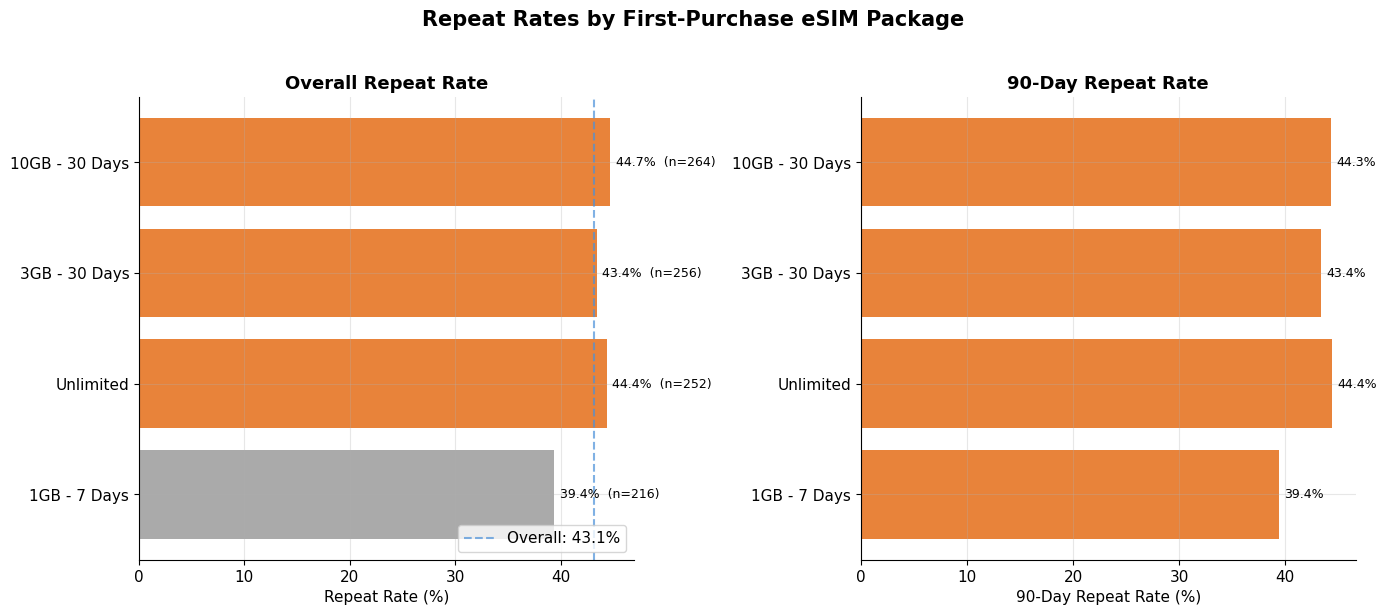

 first_package  buyers  repeat_rate  repeat_rate_90d  avg_first_purchase_usd  avg_days_to_2nd
10GB - 30 Days     264         44.7             44.3                   26.31             36.0
 3GB - 30 Days     256         43.4             43.4                   26.67             36.0
     Unlimited     252         44.4             44.4                   27.03             30.0
  1GB - 7 Days     216         39.4             39.4                   25.72             33.0


In [12]:
pkg = run("""
WITH first_purchases AS (
    SELECT
        user_id,
        order_esim_package AS first_package,
        order_package_data_gigabytes AS data_gb,
        order_package_validity_days AS validity_days,
        order_is_unlimited_package AS is_unlimited,
        order_amount_usd AS first_amount_usd
    FROM `airalo-486008.marts.orders`
    WHERE is_first_purchase
),

second_purchases AS (
    SELECT
        user_id,
        days_since_previous_purchase AS days_to_2nd
    FROM `airalo-486008.marts.orders`
    WHERE customer_purchase_number = 2
)

SELECT
    fp.first_package,
    fp.data_gb,
    fp.validity_days,
    fp.is_unlimited,
    COUNT(*) AS buyers,
    COUNTIF(sp.user_id IS NOT NULL) AS repeat_buyers,
    ROUND(COUNTIF(sp.user_id IS NOT NULL) * 100.0
        / NULLIF(COUNT(*), 0), 1) AS repeat_rate,
    ROUND(COUNTIF(sp.days_to_2nd <= 90) * 100.0
        / NULLIF(COUNT(*), 0), 1) AS repeat_rate_90d,
    ROUND(AVG(fp.first_amount_usd), 2) AS avg_first_purchase_usd,
    ROUND(AVG(sp.days_to_2nd), 0) AS avg_days_to_2nd
FROM first_purchases AS fp
LEFT JOIN second_purchases AS sp
    ON fp.user_id = sp.user_id
GROUP BY 1, 2, 3, 4
HAVING COUNT(*) >= 10
ORDER BY buyers DESC
""")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left: overall repeat rate by package
ax1 = axes[0]
overall_rate = pkg["repeat_buyers"].sum() / pkg["buyers"].sum() * 100
colors = [ORANGE if v >= overall_rate else GREY for v in pkg["repeat_rate"]]
ax1.barh(pkg["first_package"], pkg["repeat_rate"], color=colors)
ax1.axvline(overall_rate, color=BLUE, linestyle="--", linewidth=1.5, alpha=0.7,
            label=f"Overall: {overall_rate:.1f}%")
ax1.set_xlabel("Repeat Rate (%)")
ax1.set_title("Overall Repeat Rate", fontsize=13, fontweight="bold")
ax1.legend(loc="lower right")
ax1.invert_yaxis()

for i, row in pkg.iterrows():
    ax1.text(row["repeat_rate"] + 0.5, i,
             f"{row['repeat_rate']}%  (n={int(row['buyers'])})",
             va="center", fontsize=9)

# Right: 90-day repeat rate by package
ax2 = axes[1]
colors_90 = [ORANGE if v >= (pkg["repeat_buyers"].sum() / pkg["buyers"].sum() * 100 * 0.8)
             else GREY for v in pkg["repeat_rate_90d"]]
ax2.barh(pkg["first_package"], pkg["repeat_rate_90d"], color=colors_90)
ax2.set_xlabel("90-Day Repeat Rate (%)")
ax2.set_title("90-Day Repeat Rate", fontsize=13, fontweight="bold")
ax2.invert_yaxis()

for i, row in pkg.iterrows():
    ax2.text(row["repeat_rate_90d"] + 0.5, i,
             f"{row['repeat_rate_90d']}%",
             va="center", fontsize=9)

fig.suptitle("Repeat Rates by First-Purchase eSIM Package", fontsize=15, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

# Summary table
print(pkg[["first_package", "buyers", "repeat_rate", "repeat_rate_90d",
           "avg_first_purchase_usd", "avg_days_to_2nd"]].to_string(index=False))

**What to look for when you run this:**

- **Which packages over-index on repeat rate?** Packages above the overall average line are producing stickier customers. If a mid-tier package (e.g., 3GB - 30 Days) has a noticeably higher repeat rate than a small trial package (e.g., 1GB - 7 Days), that suggests customers who get enough data for a real experience are more likely to come back.
- **Do larger / longer packages drive more loyalty?** Compare repeat rates across the data GB and validity day tiers. If there's a clear step-up at a certain threshold, that's a signal about the minimum viable experience.
- **How does pricing relate?** The `avg_first_purchase_usd` column shows whether higher-value first purchases correlate with better retention — or whether cheaper entry points are better at getting people in the door.
- **Speed to second purchase:** `avg_days_to_2nd` per package tells you whether certain packages lead to faster re-engagement. Shorter-validity packages may naturally drive faster repeat if customers run out and need more.

Packages with low repeat rates but high volume are the re-engagement opportunity — the same logic from the channel analysis applies here. Packages with high repeat rates but low volume may be worth promoting more aggressively.

In [ ]:
---
## 6. Refund & Failure Impact on Repeat Behavior

Do customers who experience a refund or failed order come back? Three cuts: first-order outcome vs. future behavior (6a), post-refund recovery rate (6b), and whether prior negative experience changes completion rates on subsequent orders using `customer_prior_refunds` and `customer_prior_failures` (6c).

# --- 6a. Does your first order outcome predict whether you come back? ---

first_outcome = run("""
WITH first_orders AS (
    SELECT
        user_id,
        order_status AS first_order_status,
        order_amount_usd AS first_order_amount_usd
    FROM `airalo-486008.marts.orders`
    WHERE customer_attempt_number = 1
),

customer_future AS (
    SELECT
        fo.user_id,
        fo.first_order_status,
        fo.first_order_amount_usd,
        c.total_orders,
        c.completed_orders,
        c.total_revenue_usd,
        c.is_repeat_purchaser,
        c.has_repeat_within_90d,
        c.days_to_second_purchase
    FROM first_orders AS fo
    INNER JOIN `airalo-486008.marts.customers` AS c
        ON fo.user_id = c.user_id
    WHERE c.total_orders > 0
)

SELECT
    first_order_status,
    COUNT(*) AS customers,
    COUNTIF(total_orders > 1) AS placed_another_order,
    ROUND(COUNTIF(total_orders > 1) * 100.0
        / NULLIF(COUNT(*), 0), 1) AS pct_placed_another,
    COUNTIF(is_repeat_purchaser) AS repeat_purchasers,
    ROUND(COUNTIF(is_repeat_purchaser) * 100.0
        / NULLIF(COUNT(*), 0), 1) AS repeat_rate,
    ROUND(COUNTIF(has_repeat_within_90d) * 100.0
        / NULLIF(COUNT(*), 0), 1) AS repeat_rate_90d,
    ROUND(AVG(total_revenue_usd), 2) AS avg_lifetime_revenue_usd,
    ROUND(AVG(CASE WHEN days_to_second_purchase IS NOT NULL
        THEN days_to_second_purchase END), 0) AS avg_days_to_2nd
FROM customer_future
GROUP BY 1
ORDER BY customers DESC
""")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: % who placed another order (any status)
ax1 = axes[0]
colors = [GREEN if s == "completed" else ORANGE if s == "refunded" else GREY
          for s in first_outcome["first_order_status"]]
ax1.barh(first_outcome["first_order_status"], first_outcome["pct_placed_another"],
         color=colors)
ax1.set_xlabel("% Who Placed Another Order")
ax1.set_title("Return Rate by First Order Outcome", fontsize=13, fontweight="bold")
ax1.invert_yaxis()

for i, row in first_outcome.iterrows():
    ax1.text(row["pct_placed_another"] + 0.5, i,
             f"{row['pct_placed_another']}%  (n={int(row['customers'])})",
             va="center", fontsize=10)

# Right: avg lifetime revenue
ax2 = axes[1]
ax2.barh(first_outcome["first_order_status"], first_outcome["avg_lifetime_revenue_usd"],
         color=colors)
ax2.set_xlabel("Avg Lifetime Revenue (USD)")
ax2.set_title("Lifetime Value by First Order Outcome", fontsize=13, fontweight="bold")
ax2.invert_yaxis()

for i, row in first_outcome.iterrows():
    ax2.text(row["avg_lifetime_revenue_usd"] + 0.5, i,
             f"${row['avg_lifetime_revenue_usd']:.0f}",
             va="center", fontsize=10)

fig.suptitle("Does First Order Outcome Predict Customer Value?",
             fontsize=15, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

print(first_outcome.to_string(index=False))

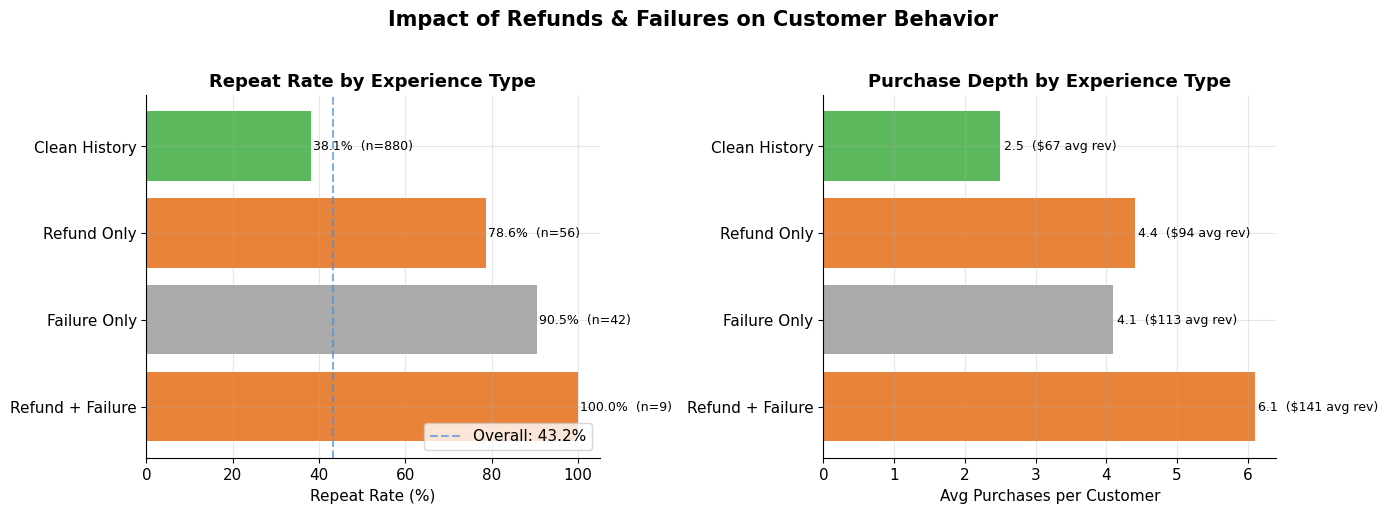

 experience_type  customers  repeat_purchasers  repeat_rate  repeat_rate_90d  avg_revenue_usd  avg_purchases  avg_days_to_2nd
   Clean History        880                335         38.1             38.1            66.77            2.5             33.0
     Refund Only         56                 44         78.6             78.6            94.45            4.4             35.0
    Failure Only         42                 38         90.5             88.1           113.46            4.1             43.0
Refund + Failure          9                  9        100.0            100.0           141.31            6.1             40.0


In [13]:
# --- 6a. Repeat rates: customers with vs without refunds/failures ---

refund_impact = run("""
WITH customer_experience AS (
    SELECT
        user_id,
        COUNTIF(order_is_refunded) AS refunds,
        COUNTIF(order_is_failed) AS failures,
        COUNTIF(order_is_completed) AS completions,
        COUNT(*) AS total_orders
    FROM `airalo-486008.marts.orders`
    GROUP BY 1
),

classified AS (
    SELECT
        CASE
            WHEN refunds > 0 AND failures > 0 THEN 'Refund + Failure'
            WHEN refunds > 0 THEN 'Refund Only'
            WHEN failures > 0 THEN 'Failure Only'
            ELSE 'Clean History'
        END AS experience_type,
        c.*
    FROM `airalo-486008.marts.customers` AS c
    INNER JOIN customer_experience AS ce
        ON c.user_id = ce.user_id
    WHERE c.total_purchases > 0
)

SELECT
    experience_type,
    COUNT(*) AS customers,
    COUNTIF(is_repeat_purchaser) AS repeat_purchasers,
    ROUND(COUNTIF(is_repeat_purchaser) * 100.0
        / NULLIF(COUNT(*), 0), 1) AS repeat_rate,
    ROUND(COUNTIF(has_repeat_within_90d) * 100.0
        / NULLIF(COUNT(*), 0), 1) AS repeat_rate_90d,
    ROUND(AVG(total_revenue_usd), 2) AS avg_revenue_usd,
    ROUND(AVG(total_purchases), 1) AS avg_purchases,
    ROUND(AVG(CASE WHEN days_to_second_purchase IS NOT NULL
        THEN days_to_second_purchase END), 0) AS avg_days_to_2nd
FROM classified
GROUP BY 1
ORDER BY customers DESC
""")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: overall repeat rate
ax1 = axes[0]
overall = refund_impact["repeat_purchasers"].sum() / refund_impact["customers"].sum() * 100
colors = [GREEN if t == "Clean History" else ORANGE if "Refund" in t else GREY
          for t in refund_impact["experience_type"]]
ax1.barh(refund_impact["experience_type"], refund_impact["repeat_rate"], color=colors)
ax1.axvline(overall, color=BLUE, linestyle="--", linewidth=1.5, alpha=0.7,
            label=f"Overall: {overall:.1f}%")
ax1.set_xlabel("Repeat Rate (%)")
ax1.set_title("Repeat Rate by Experience Type", fontsize=13, fontweight="bold")
ax1.legend(loc="lower right")
ax1.invert_yaxis()

for i, row in refund_impact.iterrows():
    ax1.text(row["repeat_rate"] + 0.5, i,
             f"{row['repeat_rate']}%  (n={int(row['customers'])})",
             va="center", fontsize=9)

# Right: avg purchases per customer
ax2 = axes[1]
ax2.barh(refund_impact["experience_type"], refund_impact["avg_purchases"], color=colors)
ax2.set_xlabel("Avg Purchases per Customer")
ax2.set_title("Purchase Depth by Experience Type", fontsize=13, fontweight="bold")
ax2.invert_yaxis()

for i, row in refund_impact.iterrows():
    ax2.text(row["avg_purchases"] + 0.05, i,
             f"{row['avg_purchases']:.1f}  (${row['avg_revenue_usd']:.0f} avg rev)",
             va="center", fontsize=9)

fig.suptitle("Impact of Refunds & Failures on Customer Behavior",
             fontsize=15, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

print(refund_impact.to_string(index=False))

In [14]:
# --- 6b. Recovery rate: after a refund, do customers complete another order? ---
# Uses the new customer_prior_refunds field from the orders mart.

recovery = run("""
WITH first_refund AS (
    SELECT
        user_id,
        MIN(order_created_at) AS first_refund_at
    FROM `airalo-486008.marts.orders`
    WHERE order_is_refunded
    GROUP BY 1
),

post_refund AS (
    SELECT
        fr.user_id,
        COUNTIF(o.order_is_completed AND o.order_created_at > fr.first_refund_at)
            AS completions_after_refund,
        MIN(CASE
            WHEN o.order_is_completed AND o.order_created_at > fr.first_refund_at
            THEN DATE_DIFF(
                CAST(o.order_created_at AS DATE),
                CAST(fr.first_refund_at AS DATE),
                DAY
            )
        END) AS days_to_recovery
    FROM first_refund AS fr
    LEFT JOIN `airalo-486008.marts.orders` AS o
        ON fr.user_id = o.user_id
    GROUP BY 1
)

SELECT
    COUNT(*) AS customers_with_refund,
    COUNTIF(completions_after_refund > 0) AS recovered,
    ROUND(COUNTIF(completions_after_refund > 0) * 100.0
        / NULLIF(COUNT(*), 0), 1) AS recovery_rate_pct,
    ROUND(AVG(CASE WHEN completions_after_refund > 0
        THEN completions_after_refund END), 1) AS avg_completions_after,
    ROUND(AVG(CASE WHEN days_to_recovery IS NOT NULL
        THEN days_to_recovery END), 0) AS avg_days_to_recovery,
    ROUND(APPROX_QUANTILES(
        CASE WHEN days_to_recovery IS NOT NULL THEN days_to_recovery END,
        100 IGNORE NULLS
    )[OFFSET(50)], 0) AS median_days_to_recovery
FROM post_refund
""")

r = recovery.iloc[0]
print("=== Post-Refund Recovery ===")
print(f"Customers who had a refund:    {int(r['customers_with_refund'])}")
print(f"Recovered (completed after):   {int(r['recovered'])}  ({r['recovery_rate_pct']}%)")
if pd.notna(r['avg_completions_after']):
    print(f"Avg completions after refund:  {r['avg_completions_after']:.1f}")
    print(f"Time to recovery:              {r['avg_days_to_recovery']:.0f} days avg  /  {r['median_days_to_recovery']:.0f} days median")

=== Post-Refund Recovery ===
Customers who had a refund:    65
Recovered (completed after):   44  (67.7%)
Avg completions after refund:  2.8
Time to recovery:              33 days avg  /  32 days median


In [ ]:
**What to look for when you run this:**

- **6a — First order outcome:** Every customer has exactly one first order, so this comparison is apples-to-apples. If customers whose first order was refunded come back at a *lower* rate than those whose first order completed, refunds are a real churn trigger — and the gap sizes the opportunity for a post-refund recovery flow. If the gap is small, refunds aren't the problem and re-engagement efforts should focus elsewhere.
- **6b — Recovery rate:** Of customers who had a refund at any point, what % went on to complete another order? This tells you how many customers self-recover without intervention — the delta between this rate and 100% is the addressable target for a recovery campaign.
- **6c — Prior experience and next-order outcome:** Does having prior refunds or failures change the completion rate on subsequent orders? This controls for customer engagement (every row is an order that was actually placed), isolating whether prior negative experience compounds into future problems.

The `customer_prior_refunds` and `customer_prior_failures` fields on the orders mart enable further drill-downs in Lightdash — filter any orders chart by prior experience to see how it interacts with destination, package, channel, etc.

**What to look for when you run this:**

- **6a — Experience type segmentation:** Compares repeat rates across four groups: clean history, refund only, failure only, and both. If refund customers have *higher* repeat rates than clean-history customers, that's a survivorship signal — they were engaged enough to get a refund rather than just churning silently. If they have *lower* rates, refunds are a friction point that needs a recovery flow.
- **6b — Recovery rate:** Of customers who had a refund, what % went on to complete another order? This is the "second chance" conversion rate. A low recovery rate with a high customer count is a concrete re-engagement opportunity — these customers already demonstrated purchase intent.
- **6c — Prior experience and next-order outcome:** Does having prior refunds or failures change the completion rate on subsequent orders? If completion rate stays flat regardless of prior experience, the negative events aren't predictive of future behavior. If it drops, there may be a compounding trust problem that needs intervention earlier in the journey.

The `customer_prior_refunds` and `customer_prior_failures` fields on the orders mart enable further drill-downs in Lightdash — filter any orders chart by prior experience to see how it interacts with destination, package, channel, etc.

---
## Limitations

**Cohort trend analysis not included.** The mart provides `customers.acquisition_cohort_month` and `customers.has_repeat_within_90d`, which are the right building blocks for tracking whether cohort quality is improving over time. However, this dataset is a sample of ~1,000 customers, which means monthly cohorts contain only 40-60 people each. At that size, a few customers swinging either way creates large percentage moves that look like trends but are noise. If the sample wasn't drawn uniformly across time, the trend would also reflect sampling bias rather than real changes in customer quality.

This analysis should be run against the full customer population, where cohort sizes are large enough for the trend to be meaningful. The query pattern is straightforward — group by `acquisition_cohort_month`, measure `has_repeat_within_90d` rate, filter to cohorts with 90+ days of maturity.

**No satisfaction signals.** The 57% one-time buyer rate is the theoretical ceiling for re-engagement, not the addressable audience. Without NPS, CSAT, support ticket, or refund data joined in, we can't distinguish "didn't need another eSIM" from "had a bad experience." Campaign targeting should filter on available satisfaction proxies before spending.